## Notebook 8: Random Forest Classifier x XGBoost Ensemble Model

Create the highest-performing model by ensembling our two best classifiers: the tuned RandomForest and the tuned XGBoost model.

### Setup

In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import ast
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully.")

Libraries imported successfully.


###  Load the Processed Data

In [8]:
try:
    df = pd.read_csv('data/processed/dili_data_clean.csv')
    print("Processed data loaded successfully.")
    print(f"Shape of the dataset: {df.shape}")
except FileNotFoundError:
    print("Error: dili_data_clean.csv not found.")
    print("Please make sure you have uploaded the file to your Colab session.")

Processed data loaded successfully.
Shape of the dataset: (907, 5)


### Prepare the Data for Modelling

In [9]:
# Drop rows with missing fingerprints
df.dropna(subset=['fingerprint'], inplace=True)
print(f"Shape after dropping NaNs: {df.shape}")

# Safely convert the string representation of the list back into a list of integers
df['fingerprint'] = df['fingerprint'].apply(ast.literal_eval)

# Separate features (X) and target (y)
X = np.array(df['fingerprint'].tolist())
y = df['dili_concern'].values

# Create a train/test split for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nData prepared for modeling:")
print(f" - Training features shape: {X_train.shape}")
print(f" - Testing features shape:  {X_test.shape}")


Shape after dropping NaNs: (907, 5)

Data prepared for modeling:
 - Training features shape: (725, 1024)
 - Testing features shape:  (182, 1024)


### Train the Tuned Models

In [10]:
# Train the Tuned RandomForest Model
print("Training the tuned RandomForest model...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
print("RandomForest training complete.")

# Train the Tuned XGBoost Model
# Best parameters found by Optuna
best_xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 42,
    'n_estimators': 349,
    'max_depth': 9,
    'learning_rate': 0.013094879048120515,
    'subsample': 0.7701118471150662,
    'colsample_bytree': 0.8656908580435939,
    'gamma': 0.03486754343407765,
    'min_child_weight': 1
}

# Add class weight balancing
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
best_xgb_params['scale_pos_weight'] = neg_count / pos_count if pos_count > 0 else 1

print("\nTraining the tuned XGBoost model...")
xgb_model = xgb.XGBClassifier(**best_xgb_params)
xgb_model.fit(X_train, y_train)
print("XGBoost training complete.")

Training the tuned RandomForest model...
RandomForest training complete.

Training the tuned XGBoost model...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:45:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost training complete.


### Create and Evaluate the Ensemble Model

In [11]:
# Predicted probabilities from both models on the test set
print("\nGenerating predictions from individual models...")
rf_probs = rf_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
print(f" - RandomForest probabilities shape: {rf_probs.shape}")
print(f" - XGBoost probabilities shape:      {xgb_probs.shape}")

# Simple Averaging Ensemble
# Combine the predictions by taking their average
ensemble_probs = (rf_probs + xgb_probs) / 2.0
print(f"\nEnsemble probabilities calculated. Shape: {ensemble_probs.shape}")

# Convert probabilities to final 0/1 predictions
ensemble_preds = (ensemble_probs > 0.5).astype(int)

# Calculate Final Metrics
ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
ensemble_roc_auc = roc_auc_score(y_test, ensemble_probs) # Use probabilities for ROC AUC

print("\n--- Final Ensemble Model Performance ---")
print(f"Accuracy on Test Set: {ensemble_accuracy:.3f}")
print(f"ROC AUC on Test Set:  {ensemble_roc_auc:.3f}")



Generating predictions from individual models...
 - RandomForest probabilities shape: (182,)
 - XGBoost probabilities shape:      (182,)

Ensemble probabilities calculated. Shape: (182,)

--- Final Ensemble Model Performance ---
Accuracy on Test Set: 0.753
ROC AUC on Test Set:  0.768


### Visualize Performance

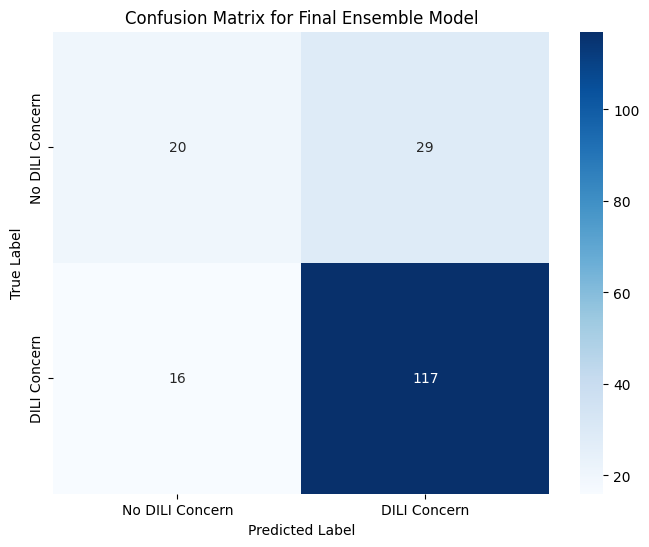

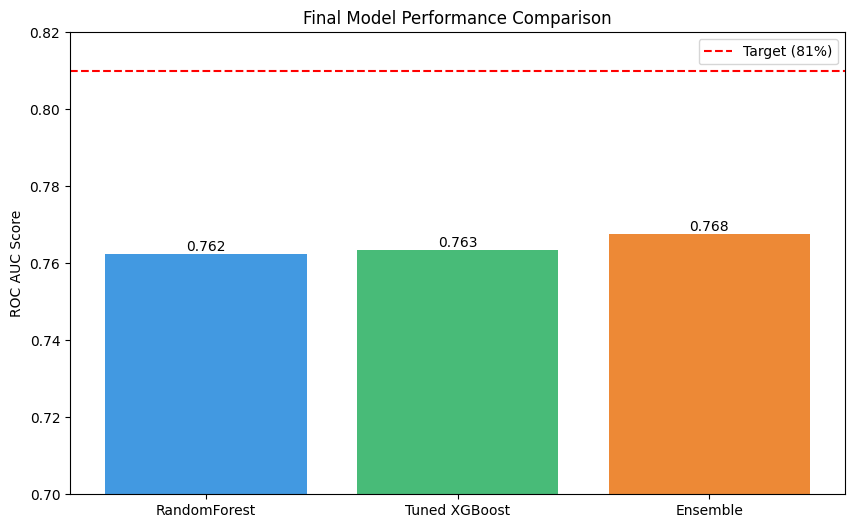

In [12]:
# Confusion Matrix for the Ensemble Model
cm = confusion_matrix(y_test, ensemble_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No DILI Concern', 'DILI Concern'],
            yticklabels=['No DILI Concern', 'DILI Concern'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Final Ensemble Model')
plt.show()

# ROC AUC Comparison Chart
# Get the individual model performances for a fair comparison
rf_test_roc_auc = roc_auc_score(y_test, rf_probs)
xgb_test_roc_auc = roc_auc_score(y_test, xgb_probs)

model_names = ['RandomForest', 'Tuned XGBoost', 'Ensemble']
roc_auc_scores = [rf_test_roc_auc, xgb_test_roc_auc, ensemble_roc_auc]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, roc_auc_scores, color=['#4299E1', '#48BB78', '#ED8936'])
plt.ylabel('ROC AUC Score')
plt.title('Final Model Performance Comparison')
plt.ylim(0.7, 0.82) # Zoom in on the relevant score range
plt.axhline(y=0.81, color='r', linestyle='--', label='Target (81%)')
plt.legend()

# Add score labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center')

plt.show()


### Final Comparison and Conclusion

In [13]:
print("\n--- Final Model Comparison ---")
print("Metric         | RandomForest | Tuned XGBoost | Ensemble Model")
print("----------------|--------------|---------------|----------------")
print(f"ROC AUC       | {rf_test_roc_auc:.3f}        | {xgb_test_roc_auc:.3f}         | {ensemble_roc_auc:.3f}")


--- Final Model Comparison ---
Metric         | RandomForest | Tuned XGBoost | Ensemble Model
----------------|--------------|---------------|----------------
ROC AUC       | 0.762        | 0.763         | 0.768
